In [12]:
from openai import OpenAI
import json
from http import HTTPStatus
from urllib.parse import urlparse, unquote
from pathlib import PurePosixPath
import requests
import dashscope
from dashscope import ImageSynthesis
import base64
from PIL import Image

api_key = 'sk-5016815ae8024398b144b5f760104f35'

In [7]:
# Step1: Conceptualizing the Global Scene.

client = OpenAI(
    api_key=api_key, 
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)

prompt = '''
You are now a scene planner tasked with using your rich imagination to design a global scene based on the theme provided by the user. Your job is to describe the environment and layout of the scene as thoroughly as possible and then output it into a concise description of no more than 50 words. This description will be used to generate the corresponding global scene, which can include various styles such as anime, realism, art, abstract, etc. Note: You only need to output the final summary result, and it must not include any theme or character information.
Here are some examples.
Theme1: ''Golden Fields Dancing in the Morning Breeze.''
Description1: Endless golden fields stretch under a soft morning sun, each stalk swaying gently in the cool breeze. The air is fresh with the scent of earth, while distant hills provide a peaceful backdrop. A serene, almost hypnotic rhythm flows through the landscape as the fields shimmer in the light.
Theme2: ''Mystical Cave Glowing with Crystal Light.''
Description2: A vast cavern filled with shimmering crystals, their luminous glow casting ethereal reflections on the surrounding stone. The air is thick with the scent of earth and minerals. The cave walls pulse with a gentle, mystical light, creating a tranquil, otherworldly atmosphere as soft echoes fill the space.
Theme3: ''Radiant Urban Skyline at Sunset.''
Description3: A vibrant city skyline bathed in the warm hues of a setting sun, its glass and steel towers reflecting the golden light. The horizon is ablaze with orange and purple tones, while the streets below bustle with life. The scene is a blend of modern energy and serene twilight beauty.
Theme: ''{}.''
Now, here is a new theme. Please imitate the examples above and provide the corresponding output.

'''

theme = "Empire of Frost and Sand" # input your theme
custom_prompt = prompt.format(theme)
completion = client.chat.completions.create(
    model="qwen-vl-max-latest",  # model list: //help.aliyun.com/zh/model-studio/getting-started/models
    messages=[
        {'role': 'system', 'content': 'You are a helpful assistant.'},
        {'role': 'user', 'content': custom_prompt}],
)
# parse results
data = json.loads(completion.model_dump_json())
global_scene_desciption = data['choices'][0]['message']['content']
print(global_scene_desciption)


A vast desert of frozen dunes stretches beneath a pale blue sky, where crystalline sands shimmer under the cold sun. Towering ice spires rise like ancient ruins, their surfaces etched with frost patterns. Wind howls across the barren expanse, carrying whispers of forgotten empires. The air is sharp and still, holding the silence of a world caught between fire and ice.


In [8]:
# Step2: Visualizing the Global Scene.

def sample_block_call(model, input_prompt, output_path=''):
    rsp = ImageSynthesis.call(model=model,
                              prompt=input_prompt,
                              size='1024*1024')
    if rsp.status_code == HTTPStatus.OK:
        print(rsp.output)
        print(rsp.usage)
        # save file to current directory
        for result in rsp.output.results:
            file_name = PurePosixPath(unquote(urlparse(result.url).path)).parts[-1]
            with open(output_path, 'wb+') as f:
                f.write(requests.get(result.url).content)
    else:
        print('Failed, status_code: %s, code: %s, message: %s' %
              (rsp.status_code, rsp.code, rsp.message))

def sample_async_call(model, input_prompt):
    rsp = ImageSynthesis.async_call(model=model,
                                    prompt=input_prompt,
                                    size='1024*1024')
    if rsp.status_code == HTTPStatus.OK:
        print(rsp.output)
        print(rsp.usage)
    else:
        print('Failed, status_code: %s, code: %s, message: %s' %
              (rsp.status_code, rsp.code, rsp.message))
    status = ImageSynthesis.fetch(rsp)
    if status.status_code == HTTPStatus.OK:
        print(status.output.task_status)
    else:
        print('Failed, status_code: %s, code: %s, message: %s' %
              (status.status_code, status.code, status.message))
    rsp = ImageSynthesis.wait(rsp)
    if rsp.status_code == HTTPStatus.OK:
        print(rsp.output)
    else:
        print('Failed, status_code: %s, code: %s, message: %s' %
              (rsp.status_code, rsp.code, rsp.message))

model = "flux-dev"
dashscope.api_key= api_key
save_path = './global_scenes/00000.png'
global_scene_desciption = global_scene_desciption # input your global scene desciption

sample_block_call(model, global_scene_desciption, save_path)
sample_async_call(model, global_scene_desciption)

{"task_id": "099a4473-2180-4a92-a732-6b95249d8d2b", "task_status": "SUCCEEDED", "results": [{"url": "https://dashscope-result-bj.oss-cn-beijing.aliyuncs.com/1d/a0/20250927/479cfa1d/ade3d022-1c4d-4780-b2a7-1f42254ed9d4-1-1.png?Expires=1759053476&OSSAccessKeyId=LTAI5tKPD3TMqf2Lna1fASuh&Signature=%2BvMZSIoniKwMQfjPDbgIcIdaba8%3D"}], "submit_time": "2025-09-27 17:57:28.002", "scheduled_time": "2025-09-27 17:57:28.043", "end_time": "2025-09-27 17:57:56.878", "task_metrics": {"TOTAL": 1, "SUCCEEDED": 1, "FAILED": 0}}
{"image_count": 1}
{"task_id": "fa754bab-2231-4fd3-8a4a-9ca329b785c1", "task_status": "PENDING", "results": []}
None
RUNNING
{"task_id": "fa754bab-2231-4fd3-8a4a-9ca329b785c1", "task_status": "SUCCEEDED", "results": [{"url": "https://dashscope-result-bj.oss-cn-beijing.aliyuncs.com/1d/41/20250927/479cfa1d/5323fe30-5993-4de4-9813-5ae5ee9b0ec0-1-1.png?Expires=1759053509&OSSAccessKeyId=LTAI5tKPD3TMqf2Lna1fASuh&Signature=hbLsjPXwNZxQCT6REqUaPMOwztQ%3D"}], "submit_time": "2025-09-27 1

In [9]:
# Step3: Crafting Local Scenes and Stories.

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

base64_image = encode_image("./global_scenes/scene_00000.png") # input your generated global scene 

prompt = '''
Now you are a story director. Please fully utilize this 1024x1024 image, unleash your imagination, and design suitable scenes from a spatial perspective for the theme "{}" while creating corresponding storylines for each scene from a temporal perspective.

Specific Requirements:
1.Spatial Design: Select 4 distinct sub-scenes from the image, ensuring that their areas are as large as possible, but not too large. Provide the top-left and bottom-right coordinates for each sub-scene in the format: [x1, y1, x2, y2].
2.Temporal Storytelling:
Create 5 unique stories for each sub-scene (20 stories in total). Each story should center around a protagonist and describe their experience in that specific scene.
3.Story Summary: 
Each story must clearly reflect the protagonist's action or experience and be summarized in one sentence (no more than 15 words).
4.Protagonist Setup:
The protagonist can be an animal or a human. If using a human, use generic pronouns like "girl," "man," etc., instead of specific names.
5.Creativity and Coherence:
Fully unleash your creativity, ensuring that each scene and story is engaging and captivating while maintaining uniqueness and overall narrative coherence.

Output Format:
Only provide the coordinates in the [x1, y1, x2, y2] format for each sub-scene, followed by the stories happening in each sub-scene.

Example:
[248, 132, 512, 512]

1. A lone wolf treks across the scorching desert, seeking shelter.
2. The girl finds a hidden oasis, quenching her thirst under the blazing sun.
3. An old man watches the sunset, reminiscing about his adventurous life.
4. A family of rabbits burrow deep into the cool earth to escape the heat.
5. A bird soars high above, searching for food in the vast desert expanse.

[798, 104, 1024, 512]

1. A polar bear roams the icy tundra, hunting for seals in the freezing cold.
2. The man builds an igloo, preparing for the harsh winter night ahead.
3. A group of penguins huddle together, staying warm against the bitter wind.
4. A fisherman braves the icy waters, hoping for a good catch.
5. A snow leopard stalks silently through the snow, tracking its prey.

[56, 501, 596, 1008]

1. A camel caravan crosses the cracked earth, carrying precious water supplies.
2. The girl discovers a hidden spring, filling her canteen with fresh water.
3. An elderly sage meditates under a lone tree, finding peace in the desert.
4. A tribe of nomads sets up camp, resting after a long day's journey.
5. A snake slithers through the sand, hunting for small rodents.

[105, 612, 1008, 1008]

1. A seal pup plays on the ice floes, learning to navigate the frozen sea.
2. The man ice fishes, patiently waiting for a bite in the frigid waters.
3. A flock of arctic birds flies overhead, migrating to warmer climates.
4. A walrus rests on the ice, basking in the cold sunlight.
5. A group of tourists explore the icy landscape, marveling at its beauty.
'''
prompt.format(theme)


client = OpenAI(
    api_key=api_key,
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)
completion = client.chat.completions.create(
    model="qwen-vl-max-latest",
    messages=[{'role': 'system', 'content': 'You are a helpful assistant.'},
        {   "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{base64_image}"}, 
                },
                {"type": "text", "text": prompt},
            ],
        }
    ],
)
crop_results = completion.choices[0].message.content
print(crop_results)

[10, 10, 512, 480]

1. A lone traveler gazes at the sky, dreaming of stars beyond the icy peaks.  
2. The girl releases a snow kite into the wind, watching it soar above the frozen expanse.  
3. A reindeer pauses on a ridge, sensing ancient magic in the air.  
4. An explorer plants a flag atop a distant spire, claiming territory for science.  
5. A falcon circles high, its shadow gliding over silent, jagged ice towers.

[512, 10, 1024, 480]

1. A man stands before a towering ice cathedral, whispering prayers to forgotten gods.  
2. The girl climbs the tallest spire, her breath forming frost in the thin air.  
3. A glacier spirit emerges from the ice, glowing faintly beneath the surface.  
4. A team of scientists drills into the mountain, seeking clues about Earth’s past.  
5. A dragon-like creature sleeps within the crystal core, dreaming of fire and ice.

[10, 480, 512, 1024]

1. A fox with silver fur hunts across the snowfields, tracking prey through footprints.  
2. The man builds a

Global scene dimensions: width=1024, height=1024


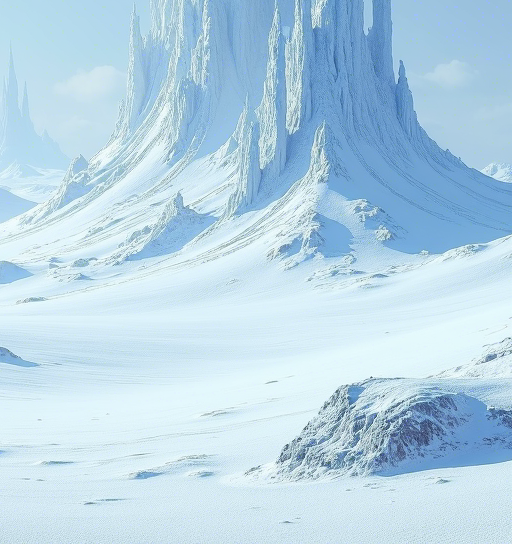

In [17]:
# Post-processing

global_scene_path = save_path  # input your generated global scene
global_scene = Image.open(global_scene_path).convert("RGB")

# get the size
width, height = global_scene.size

# Replace with your top-left coordinate (x1, y1)
top_left = (512, 480)
# Replace with your bottom-right coordinate (x2, y2)
bottom_right = (1024, 1024)


# Automatically adjust them to ensure they stay within the image edges
x1 = max(0, min(top_left[0], width - 1))
y1 = max(0, min(top_left[1], height - 1))
x2 = max(0, min(bottom_right[0], width))
y2 = max(0, min(bottom_right[1], height))

assert x2 > x1 and y2 > y1, ValueError(f"Invalid coordinates after correction: top-left=({x1},{y1}), bottom-right=({x2},{y2})")

# crop the images
cropped_image = global_scene.crop((x1, y1, x2, y2))
# save
cropped_image.save("./local_scenes/scene_00.png")
cropped_image